In [3]:
import xarray as xr
import cartopy.crs as ccrs

import math
import numpy as np

from scipy.stats import boxcox

import matplotlib.pyplot as plt

import torch

In [237]:
cp_model_rotated_pole = ccrs.RotatedPole(
    pole_longitude=177.5,
    pole_latitude=37.5
)
platecarree = ccrs.PlateCarree()


class SelectDomain:

    # Domain centres in standard latitude and longitude
    DOMAIN_CENTRES_LON_LAT = {
        "london": (-0.118092, 51.509865),
        "birmingham": (-1.898575, 52.489471),
    }

    # Domain centres in rotated pole latitude and longitude
    DOMAIN_CENTRES_RP_LONG_LAT = {
        domain_name: cp_model_rotated_pole.transform_point(
            *lon_lat, src_crs=platecarree
        )
        for domain_name, lon_lat in DOMAIN_CENTRES_LON_LAT.items()
    }

    def __init__(self, subdomain, size=64) -> None:
        self.subdomain = subdomain
        self.size = size

    def run(self, ds):

        # Find the grid square in the dataset nearest to the centre
        # Assumes dataset is in rotated pole coordinates
        centre_rp_lon_lat = self.DOMAIN_CENTRES_RP_LONG_LAT[self.subdomain]
        centre_ds = ds.sel(
            grid_longitude=360.0 + centre_rp_lon_lat[0],
            grid_latitude=centre_rp_lon_lat[1],
            method="nearest",
        )

        # Find the INDEX of the central square in the grid latitude and longitude coordinates
        centre_long_idx = np.where(
            ds.grid_longitude.values == centre_ds.grid_longitude.values
        )[0].item()
        centre_lat_idx = np.where(
            ds.grid_latitude.values == centre_ds.grid_latitude.values
        )[0].item()

        # Set how many grid squares to go up, down, left and right from the centre box
        # in order to get a box the is self.size by self.size
        radius = self.size - 1
        left_length = math.floor(radius / 2.0)
        right_length = math.ceil(radius / 2.0)
        down_length = math.floor(radius / 2.0)
        up_length = math.ceil(radius / 2.0)

        # Select only the bits of the dataset that lie in the box defined
        ds = ds.sel(
            grid_longitude=slice(
                ds.grid_longitude[centre_long_idx - left_length].values,
                ds.grid_longitude[centre_long_idx + right_length].values,
            ),
            grid_latitude=slice(
                ds.grid_latitude[centre_lat_idx - down_length].values,
                ds.grid_latitude[centre_lat_idx + up_length].values,
            ),
        )

        return ds


<xarray.Dataset>
Dimensions:                     (ensemble_member: 1, time: 720,
                                 grid_latitude: 606, grid_longitude: 484,
                                 bnds: 2)
Coordinates:
  * ensemble_member             (ensemble_member) int32 1
  * time                        (time) object 1980-12-01 00:30:00 ... 1980-12...
  * grid_latitude               (grid_latitude) float64 -4.683 -4.647 ... 8.063
  * grid_longitude              (grid_longitude) float64 353.9 354.0 ... 364.3
    ensemble_member_id          (ensemble_member) |S27 ...
    latitude                    (grid_latitude, grid_longitude) float64 ...
    longitude                   (grid_latitude, grid_longitude) float64 ...
    month_number                (time) int32 ...
    year                        (time) int32 ...
    yyyymmddhh                  (time) |S64 ...
Dimensions without coordinates: bnds
Data variables:
    pr                          (ensemble_member, time, grid_latitude, grid_longitude) float32 ...
    rotated_latitude_longitude  int32 ...
    time_bnds                   (time, bnds) object ...
    grid_latitude_bnds          (grid_latitude, bnds) float64 ...
    grid_longitude_bnds         (grid_longitude, bnds) float64 ...
Attributes: (12/15)
    collection:      land-cpm
    contact:         ukcpproject@metoffice.gov.uk
    creation_date:   2019-09-11T20:29:43
    domain:          uk
    frequency:       1hr
    institution:     Met Office Hadley Centre (MOHC), FitzRoy Road, Exeter, D...
    ...              ...
    resolution:      2.2km
    scenario:        rcp85
    source:          UKCP18 realisation from a set of 12 convection-permittin...
    title:           UKCP18 land projections - 2.2km convection-permitting cl...
    version:         v20190731
    Conventions:     CF-1.5

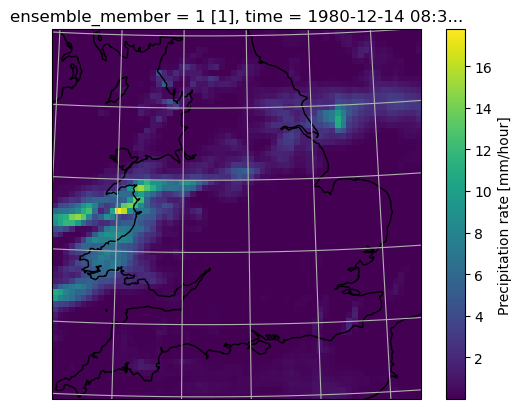

In [238]:
ds = xr.open_dataset("pr_rcp85_land-cpm_uk_2.2km_01_1hr_19801201-19801230.nc")
display(ds)

ds = ds.coarsen(grid_latitude=4, grid_longitude=4, boundary="trim").mean()
ds = SelectDomain("birmingham", size=64).run(ds)

cp_model_rotated_pole = ccrs.RotatedPole(pole_longitude=177.5, pole_latitude=37.5)
ax = plt.axes(projection=cp_model_rotated_pole)
ds.isel(time=320).pr.plot(ax = ax, x = 'longitude', y = 'latitude', transform = ccrs.PlateCarree())
ax.gridlines()
ax.coastlines()
plt.show()

In [241]:
ds = xr.open_dataset("pr_rcp85_land-cpm_uk_2.2km_01_1hr_19890701-19890730.nc")
ds = ds.coarsen(grid_latitude=4, grid_longitude=4, boundary="trim").mean()
ds = SelectDomain("birmingham", size=64).run(ds)

# ex = torch.load("data/720.pt")
# print((ds.pr.isel(time = slice(0, 10)) == ex.numpy()).all().item())

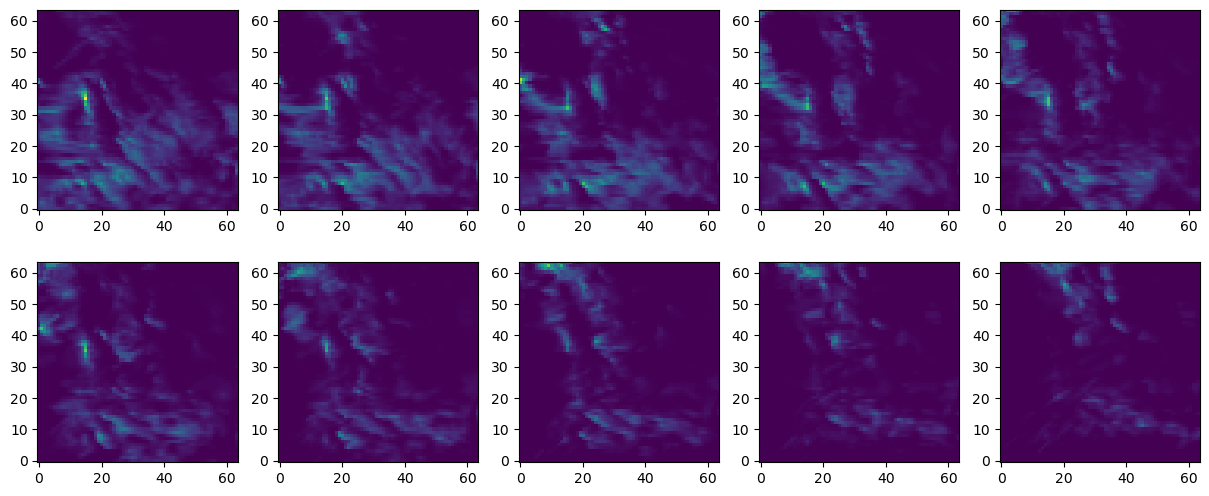

min: 1.6801472213501256e-08, max: 8.611276626586914, mean: 0.3742327094078064


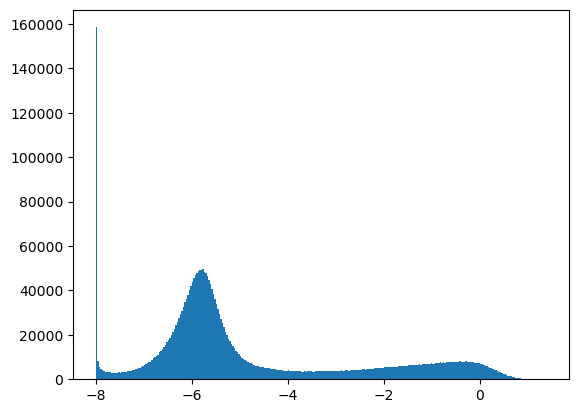

In [4]:
# ds = xr.open_dataset("~/Desktop/pr_rcp85/pr_rcp85_land-cpm_birmingham-64_2.2km-coarsened-4x-2.2km-coarsened-4x_01_1hr_19801201-19801230.nc")
# ds = xr.open_dataset("~/Desktop/pr_rcp85/pr_rcp85_land-cpm_birmingham-64_2.2km-coarsened-4x-2.2km-coarsened-4x_01_1hr_20660501-20660530.nc")
ds = xr.open_dataset("~/Desktop/pr_rcp85/pr_rcp85_land-cpm_birmingham-64_2.2km-coarsened-4x-2.2km-coarsened-4x_01_1hr_20801101-20801130.nc")

index = 150
pr = ds.isel(time = slice(index, index + 10)).pr.values[0]

fig, axs = plt.subplots(2, 5, figsize = (15, 6))
for i in range(10):
    ax = axs.flat[i]
    frame = pr[i]
    ax.imshow(frame, origin = "lower", vmin = pr.min(), vmax = pr.max())
plt.show()

print(f"min: {pr.min()}, max: {pr.max()}, mean: {pr.mean()}")

# plt.hist(np.log10(pr.flatten() + 1e-8), bins = 300)
# plt.show()

# all_values = ds.pr.values.flatten()
# plt.hist(all_values, bins = 300)
# plt.show()

all_values = ds.pr.values.flatten()
plt.hist(np.log10(all_values + 1e-8), bins = 300)
plt.show()

# all_values = ds.pr.values.flatten()
# all_values = np.sqrt(np.sqrt(np.sqrt(all_values)))
# plt.hist(all_values, bins = 300)
# plt.show()


Example 0:
min: 7.717688959019142e-07, max: 7.2757487297058105
mean: 0.37059837579727173
torch.Size([10, 64, 64])


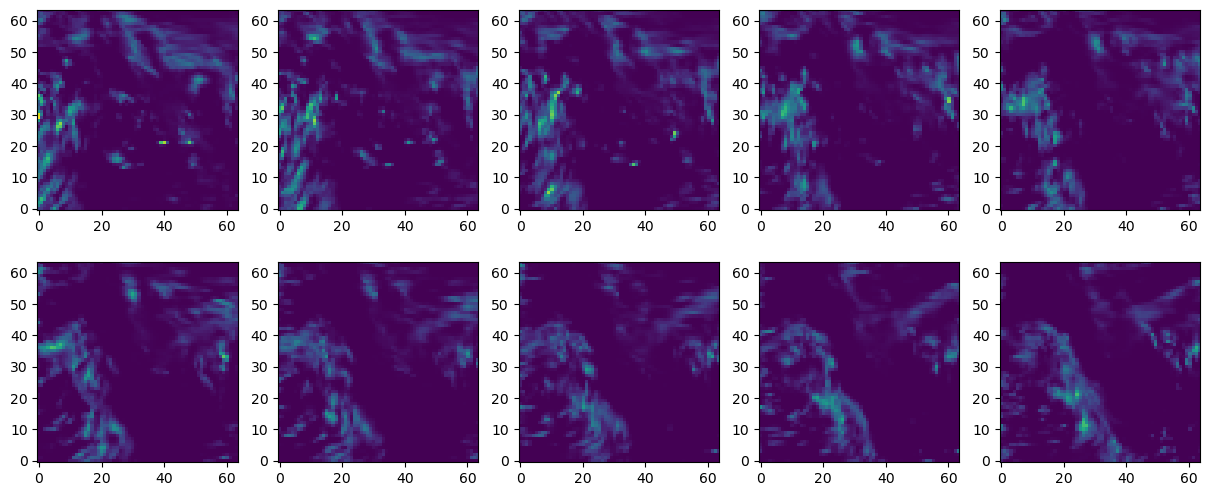

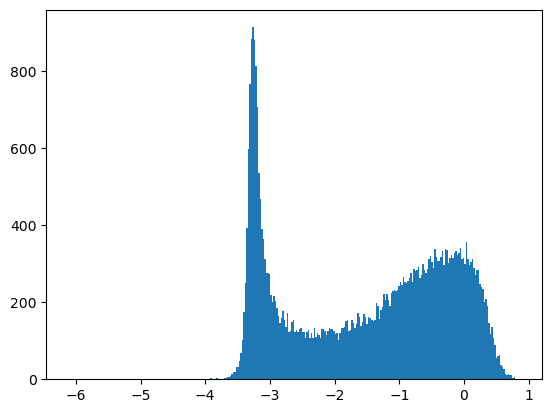


Example 1:
min: 0.0, max: 7.710274696350098
mean: 0.30817604064941406
torch.Size([10, 64, 64])


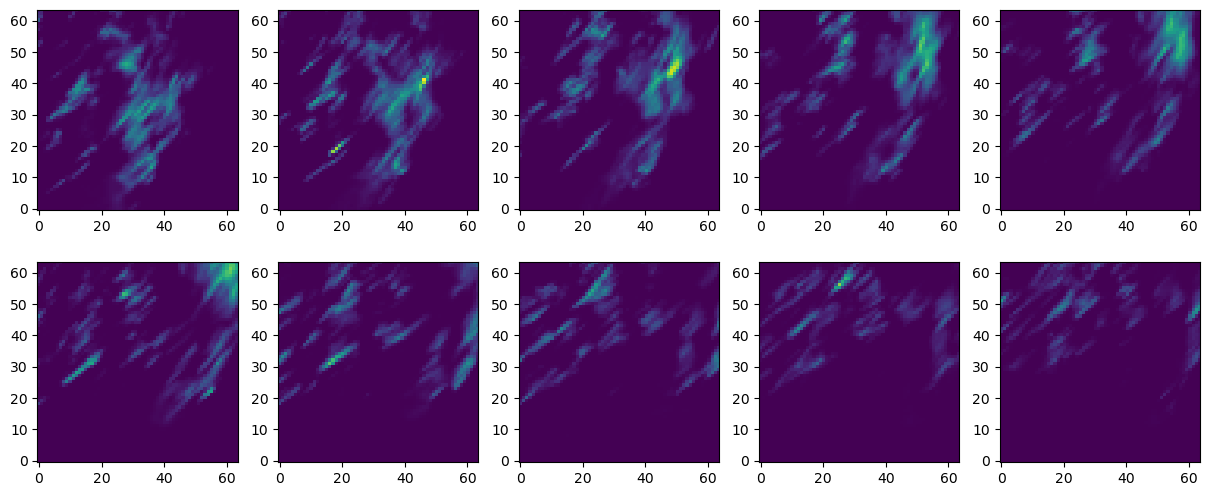

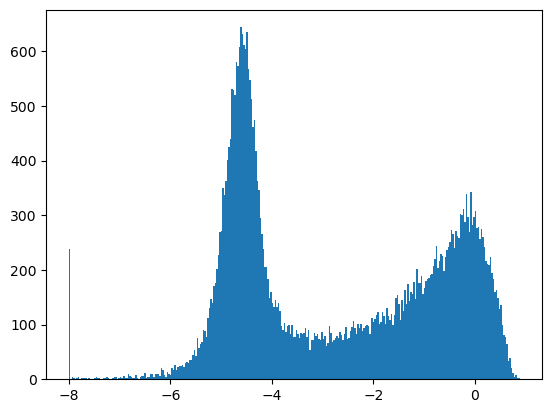


Example 2:
min: 4.5540928113041446e-06, max: 10.948273658752441
mean: 0.31859081983566284
torch.Size([10, 64, 64])


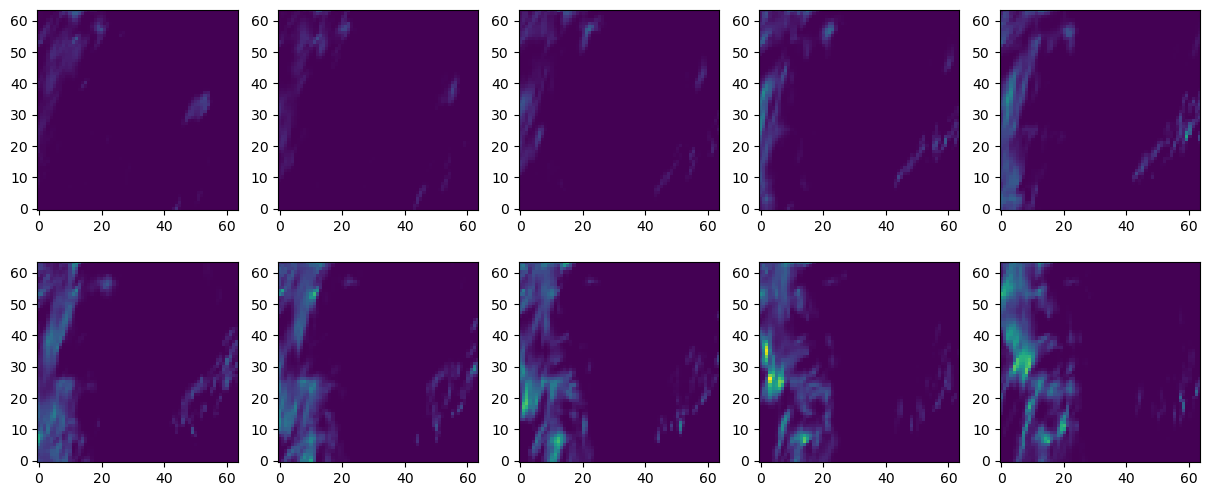

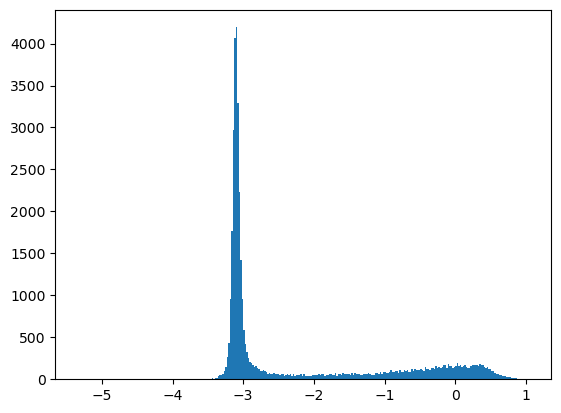


Example 3:
min: 4.452153007150628e-05, max: 11.3316650390625
mean: 0.8611189723014832
torch.Size([10, 64, 64])


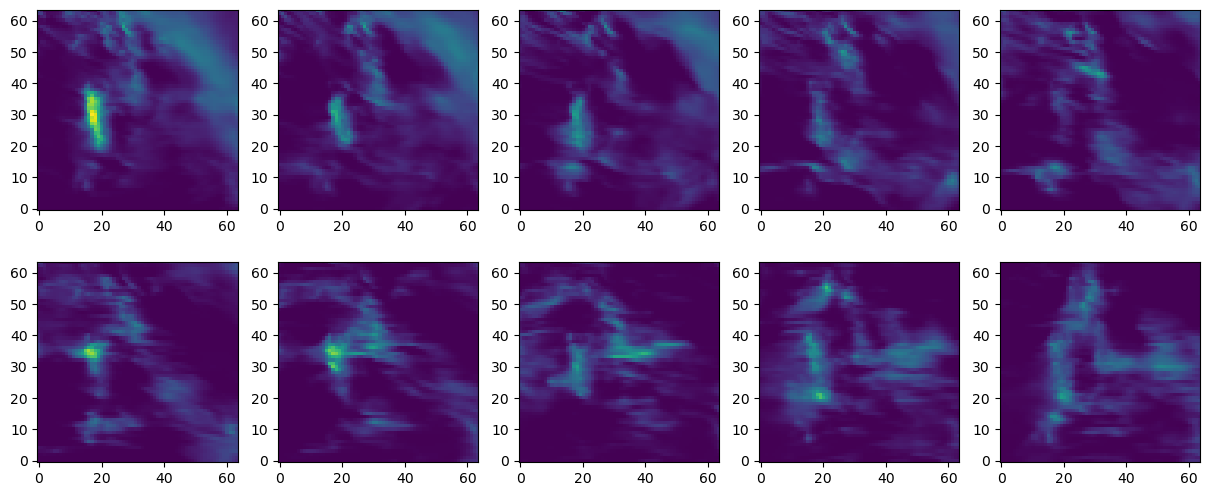

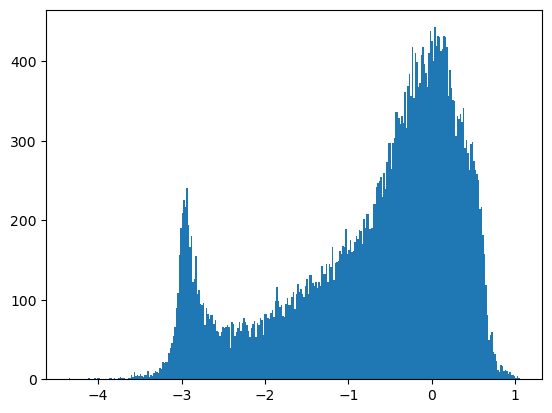


Example 4:
min: 0.0, max: 5.449953079223633
mean: 0.01994701661169529
torch.Size([10, 64, 64])


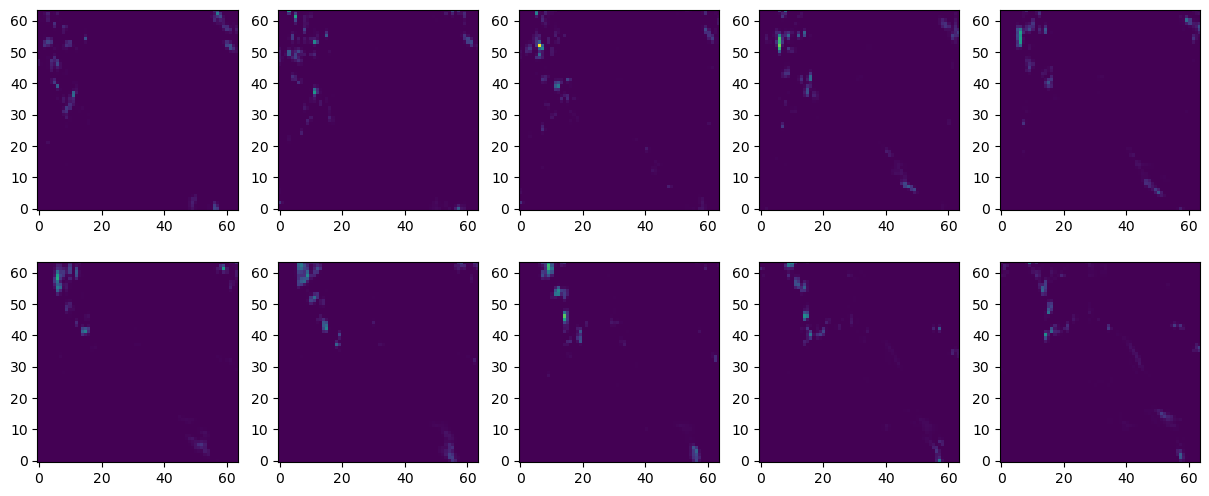

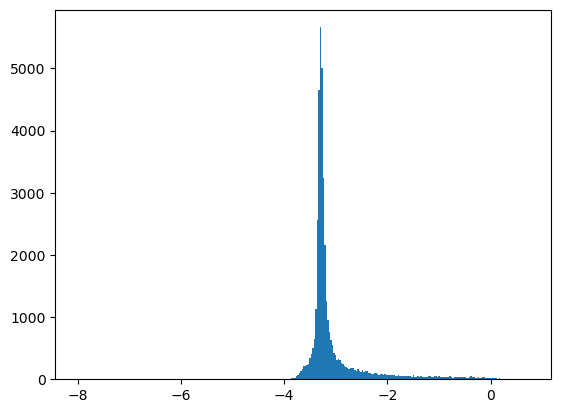


Example 5:
min: 0.0, max: 9.292974472045898
mean: 0.3077954649925232
torch.Size([10, 64, 64])


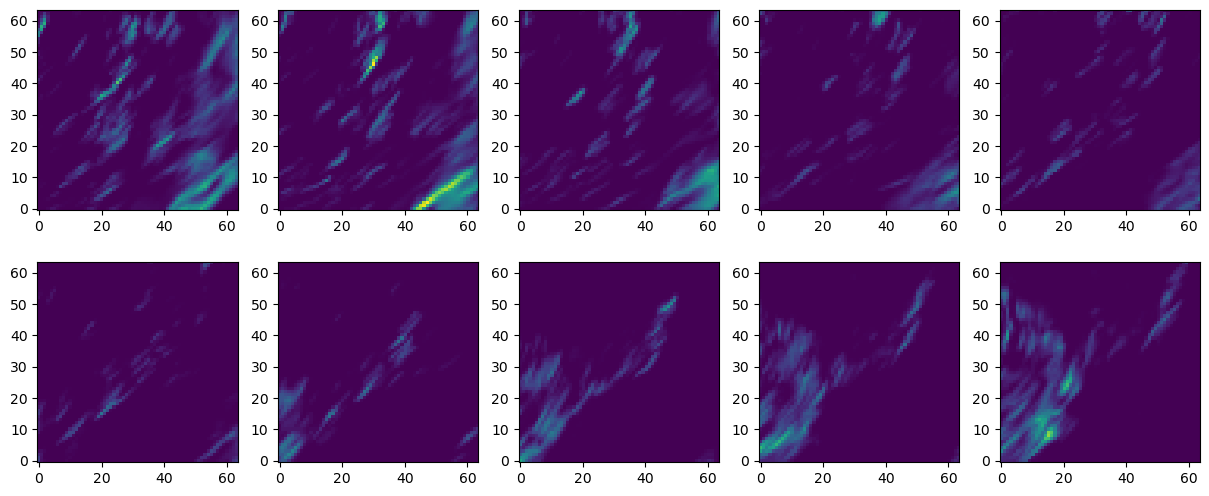

In [18]:
# ds = torch.load("../../results/results_16r/20.pt", map_location=torch.device('cpu'))
# ds = torch.load("../../results/results_2r/70.pt", map_location=torch.device('cpu'))
# ds = torch.load("../../results/results_2r_dyn/50.pt", map_location=torch.device('cpu'))
# ds = torch.load("../../results/results_4r/52.pt", map_location=torch.device('cpu'))
# ds = torch.load("../../results/results_8r/52.pt", map_location=torch.device('cpu'))

# ds = torch.load("../../results/results_2r/70.pt", map_location=torch.device('cpu'))
ds = torch.load("../../results/results_2r_l2/117.pt", map_location=torch.device('cpu'))
# ds = torch.load("../../48.pt", map_location=torch.device('cpu'))

# all_values = ds.flatten()
# plt.hist(np.log10(all_values + 1e-8), bins = 300)
# plt.show()

for i in range(16):
    ex = ds[i][0]
    print(f"\nExample {i}:")
    print(f"min: {ex.min()}, max: {ex.max()}\nmean: {ex.mean()}")
    print(ex.shape)
    fig, axs = plt.subplots(2, 5, figsize = (15, 6))
    for j in range(10):
        ax = axs.flat[j]
        frame = ex[j]
        ax.imshow(frame, origin = "lower", vmin = ex.min(), vmax = ex.max())
    plt.show()

    plt.hist(np.log10(ex.flatten() + 1e-8), bins = 300)
    plt.show()

In [250]:
# ds = xr.open_mfdataset("*.nc")
# ds = ds.coarsen(grid_latitude=4, grid_longitude=4, boundary="trim").mean()
# ds = SelectDomain("birmingham", size=64).run(ds)

# cp_model_rotated_pole = ccrs.RotatedPole(pole_longitude=177.5, pole_latitude=37.5)
# ccrs_plate_carree = ccrs.PlateCarree()

# chunk_size = 10
# chunk = 5

# fig, axs = plt.subplots(2, 5, figsize = (15, 6), subplot_kw={"projection": cp_model_rotated_pole})
# for i in range(chunk_size):
#     ax = axs.flat[i]
#     ds.isel(time = chunk * chunk_size + i).pr.plot(ax = ax, x = 'longitude', y = 'latitude', transform = ccrs_plate_carree)
#     ax.coastlines()
#     ax.set_title("")
#     ax.collections[0].colorbar.remove()
# fig.tight_layout()